In [1]:
import os
project_dir = "c:/Users/sqin34/OneDrive - UW-Madison/Research/solvgnn/"
os.chdir(project_dir)

In [2]:
import pickle
import torch
from solvgnn.model.model_GNN import solvgnn_ternary, get_n_params
from solvgnn.util.generate_dataset import solvent_dataset_ternary
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

Using backend: pytorch


In [3]:
saved_model_dir = project_dir + "results/job_220811_solvgnn_ternary_catx/"

In [4]:
valid_ind_list = np.load(saved_model_dir + 'saved_model/valid_ind_list.npy')
valid_loss_list = []
for cv_id in range(5):
    valid_loss_list.append(np.load(saved_model_dir + 'saved_model/val_loss_cv{}.npy'.format(cv_id))[-1])
print("mean CV MSE loss {:.4f}, std CV MSE loss {:.4f}".format(np.mean(valid_loss_list), np.std(valid_loss_list)))
best_cv_id = np.argmin(valid_loss_list)
print("best CV fold: {}".format(best_cv_id))

mean CV MSE loss 0.0052, std CV MSE loss 0.0003
best CV fold: 0


Load data class

In [5]:
dataset_path = project_dir + "solvgnn/data/output_ternary_all.csv"
solvent_list_path = project_dir + 'solvgnn/data/solvent_list.csv'
dataset = solvent_dataset_ternary(
    input_file_path=dataset_path,
    solvent_list_path = solvent_list_path,
    generate_all=True)

Check for permutatio invariance

In [6]:
cv_id = 0
valid_ind = valid_ind_list[cv_id]
empty_solvsys = dataset.generate_solvsys(batch_size=1)
model = solvgnn_ternary(in_dim=74, hidden_dim=256, n_classes=1).cuda()
checkpoint = torch.load(saved_model_dir + 'saved_model/final_model_cv{}.pth'.format(cv_id))
print("# model params: {}".format(get_n_params(model)))
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# model params: 2840641


solvgnn_ternary(
  (conv1): GraphConv(in=74, out=256, normalization=both, activation=None)
  (conv2): GraphConv(in=256, out=256, normalization=both, activation=None)
  (global_conv1): MPNNconv(
    (project_node_feats): Sequential(
      (0): Linear(in_features=257, out_features=256, bias=True)
      (1): ReLU()
    )
    (gnn_layer): NNConv(
      (edge_nn): Sequential(
        (0): Linear(in_features=1, out_features=32, bias=True)
        (1): ReLU()
        (2): Linear(in_features=32, out_features=65536, bias=True)
      )
    )
    (gru): GRU(256, 256)
  )
  (classify1): Linear(in_features=256, out_features=256, bias=True)
  (classify2): Linear(in_features=256, out_features=256, bias=True)
  (classify3): Linear(in_features=256, out_features=1, bias=True)
)

In [7]:
chemical_list = ["alcohol", "water", "alcohol"]
smiles_list = ["CCCO", "O", "CCO"]
solv1_x = 0.2
solv2_x = 0.2
pred = dataset.predict_new(model,chemical_list,smiles_list,solv1_x,solv2_x,gamma_list=None)
print(pred)

[-0.04077317  0.55649066 -0.01213766]


In [8]:
chemical_list = ["alcohol", "alcohol", "water"]
smiles_list = ["CCCO", "CCO", "O"]
solv1_x = 0.2
solv2_x = 0.6
pred = dataset.predict_new(model,chemical_list,smiles_list,solv1_x,solv2_x,gamma_list=None)
print(pred)

[-0.04077313 -0.01213763  0.5564908 ]


Inference individual CV samples and save for further analysis

In [6]:
idx_all = []
true_gam1_all, true_gam2_all, true_gam3_all = [], [], []
pred_gam1_all, pred_gam2_all, pred_gam3_all = [], [], []
intra_hb1_all, intra_hb2_all, intra_hb3_all = [], [], []
inter_hb12_all, inter_hb13_all, inter_hb23_all = [], [], []
solv1_x_all, solv2_x_all = [], []

In [27]:
for cv_id in range(5):
    print('Analayzing CV {}'.format(cv_id+1))
    valid_ind = valid_ind_list[cv_id]
    empty_solvsys = dataset.generate_solvsys(batch_size=1)
    model = solvgnn_ternary(in_dim=74, hidden_dim=256, n_classes=1).cuda()
    checkpoint = torch.load(saved_model_dir + 'saved_model/final_model_cv{}.pth'.format(cv_id))
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    for count,idx in enumerate(valid_ind):
        idx_all.append(idx)
        intra_hb1_all.append(dataset[idx]['intra_hb1'])
        intra_hb2_all.append(dataset[idx]['intra_hb2'])
        intra_hb3_all.append(dataset[idx]['intra_hb3'])
        inter_hb12_all.append(dataset[idx]['inter_hb12'])
        inter_hb13_all.append(dataset[idx]['inter_hb13'])
        inter_hb23_all.append(dataset[idx]['inter_hb23'])
        solv1_x_all.append(dataset[idx]['solv1_x'])
        solv2_x_all.append(dataset[idx]['solv2_x'])
        true,pred = dataset.predict(idx,model,empty_solvsys)
        pred_gam1_all.append(pred[0])
        pred_gam2_all.append(pred[1])
        pred_gam3_all.append(pred[2])
        true_gam1_all.append(true[0])
        true_gam2_all.append(true[1])
        true_gam3_all.append(true[2])
        if (count+1) % 100 == 0:
            print('{} out of {} done!'.format(count+1,len(valid_ind)))

Analayzing CV 1
100 out of 32000 done!
200 out of 32000 done!
300 out of 32000 done!
400 out of 32000 done!
500 out of 32000 done!
600 out of 32000 done!
700 out of 32000 done!
800 out of 32000 done!
900 out of 32000 done!
1000 out of 32000 done!
1100 out of 32000 done!
1200 out of 32000 done!
1300 out of 32000 done!
1400 out of 32000 done!
1500 out of 32000 done!
1600 out of 32000 done!
1700 out of 32000 done!
1800 out of 32000 done!
1900 out of 32000 done!
2000 out of 32000 done!
2100 out of 32000 done!
2200 out of 32000 done!
2300 out of 32000 done!
2400 out of 32000 done!
2500 out of 32000 done!
2600 out of 32000 done!
2700 out of 32000 done!
2800 out of 32000 done!
2900 out of 32000 done!
3000 out of 32000 done!
3100 out of 32000 done!
3200 out of 32000 done!
3300 out of 32000 done!
3400 out of 32000 done!
3500 out of 32000 done!
3600 out of 32000 done!
3700 out of 32000 done!
3800 out of 32000 done!
3900 out of 32000 done!
4000 out of 32000 done!
4100 out of 32000 done!
4200 out 

In [37]:
output_cv = pd.DataFrame({'idx':np.array(idx_all),
                          'solv1_x':np.array(solv1_x_all),
                          'solv2_x':np.array(solv2_x_all),
                          'true_gam1':np.array(true_gam1_all),
                          'pred_gam1':np.array(pred_gam1_all),
                          'true_gam2':np.array(true_gam2_all),
                          'pred_gam2':np.array(pred_gam2_all),
                          'true_gam3':np.array(true_gam3_all),
                          'pred_gam3':np.array(pred_gam3_all),
                          'intra_hb1':np.array(intra_hb1_all),
                          'intra_hb2':np.array(intra_hb2_all),
                          'intra_hb3':np.array(intra_hb3_all),
                          'inter_hb12':np.array(inter_hb12_all),
                          'inter_hb13':np.array(inter_hb13_all),
                          'inter_hb23':np.array(inter_hb23_all)                 
                          })


In [13]:
output_cv = output_cv.sort_values(by="idx").reset_index(drop=True)
raw_data = pd.read_csv(dataset_path)
raw_data = raw_data.rename(columns={"solv1_x": "solv1_x_input"})
raw_data = raw_data.rename(columns={"solv2_x": "solv2_x_input"})
raw_data = raw_data.rename(columns={"solv3_x": "solv3_x_input"})
output_cv = pd.concat([raw_data, output_cv], axis=1)
output_cv.to_csv(saved_model_dir + 'analysis/output_cv.csv',index=False)

In [10]:
import matplotlib
import matplotlib.pyplot as plt

plt.rcParams.update({
    'text.usetex': True,
    'font.family':'serif',
    'font.serif':['Computer Modern'],
    'axes.labelsize':10,
    'xtick.labelsize':9,
    'ytick.labelsize':9})

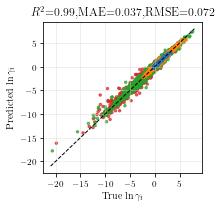

In [12]:
xmin = -21
xmax = 8
output_cv = pd.read_csv(saved_model_dir + 'analysis/output_cv.csv')
output_cv = pd.concat(
    (
        output_cv[["true_gam1", "pred_gam1", "tpsa_binary_avg"]]
        .rename(columns={
            "true_gam1": "true_gam",
            "pred_gam1": "pred_gam"}),
        output_cv[["true_gam2", "pred_gam2", "tpsa_binary_avg"]]
        .rename(columns={
            "true_gam2": "true_gam",
            "pred_gam2": "pred_gam"}),
        output_cv[["true_gam3", "pred_gam3", "tpsa_binary_avg"]]
        .rename(columns={
            "true_gam3": "true_gam",
            "pred_gam3": "pred_gam"})
    ))
output_cv = output_cv.sort_values(by="tpsa_binary_avg",ascending=False)
output_cv["tpsa_binary_avg"] = output_cv["tpsa_binary_avg"].astype("int")

color_list = matplotlib.cm.get_cmap('tab10')
labels = ["nonpolar-nonpolar-nonpolar","polar-nonpolar-nonpolar","polar-polar-nonpolar","polar-polar-polar"]
fig,ax = plt.subplots(figsize=(3,3))
ax.grid(color='lightgray',linewidth=0.75,alpha=0.5)
# ax[1].grid(color='lightgray',linewidth=0.75,alpha=0.5)
# ax[2].grid(color='lightgray',linewidth=0.75,alpha=0.5)
ax.plot([xmin, xmax], 
           [xmin, xmax], color='black',linestyle='--', lw=1)
# ax[1].plot([xmin, xmax], 
#            [xmin, xmax], color='black',linestyle='--', lw=1)
# ax[2].plot([xmin, xmax], 
#            [xmin, xmax], color='black',linestyle='--', lw=1)
ax.scatter(output_cv['true_gam'],output_cv['pred_gam'],c=color_list(output_cv['tpsa_binary_avg']),s=6,alpha=0.7)
# ax[1].scatter(output_cv['true_gam2'],output_cv['pred_gam2'],c=color_list(output_cv['tpsa_binary_avg']),s=6,alpha=0.7)
# ax[2].scatter(output_cv['true_gam3'],output_cv['pred_gam3'],c=color_list(output_cv['tpsa_binary_avg']),s=6,alpha=0.7)

ax.set_xlabel('True $\ln\gamma_i$')
ax.set_ylabel('Predicted $\ln\gamma_i$')
ax.set_title('$R^2$={:.2f},MAE={:.3f},RMSE={:.3f}'.format(r2_score(output_cv['true_gam'],output_cv['pred_gam']),
                                                  mean_absolute_error(output_cv['true_gam'],output_cv['pred_gam']),
                                                  np.sqrt(mean_squared_error(output_cv['true_gam'],output_cv['pred_gam']))))

# ax[1].set_xlabel('True $\ln\gamma_2$')
# ax[1].set_ylabel('Predicted $\ln\gamma_2$')

# ax[1].set_title('$R^2$={:.2f},MAE={:.3f},RMSE={:.3f}'.format(r2_score(output_cv['true_gam2'],output_cv['pred_gam2']),
#                                                   mean_absolute_error(output_cv['true_gam2'],output_cv['pred_gam2']),
#                                                   np.sqrt(mean_squared_error(output_cv['true_gam2'],output_cv['pred_gam2']))))
# ax[2].set_xlabel('True $\ln\gamma_3$')
# ax[2].set_ylabel('Predicted $\ln\gamma_3$')

# ax[2].set_title('$R^2$={:.2f},MAE={:.3f},RMSE={:.3f}'.format(r2_score(output_cv['true_gam3'],output_cv['pred_gam3']),
#                                                   mean_absolute_error(output_cv['true_gam3'],output_cv['pred_gam3']),
#                                                   np.sqrt(mean_squared_error(output_cv['true_gam3'],output_cv['pred_gam3']))))
ax.set_xticks(np.arange(-20,6,5))
plt.tight_layout()
plt.savefig(saved_model_dir + 'analysis/cv_parity_color.png',pad_inches=0,dpi=400,transparent=True)   

In [13]:
output_cv = pd.read_csv(saved_model_dir + 'analysis/output_cv.csv')
outlier1 = output_cv[output_cv.solv1_gamma < -18]
outlier2 = output_cv[output_cv.solv2_gamma < -18]

In [15]:
outlier1.values

array([[29196, 'solvent_505', 'solvent_540', 'solvent_708', 0.15, 0.7,
        0.15, -20.6598363, -0.35235876, 2.71026624, nan, 'NCCN', 'C#N',
        'FC(F)(F)C1(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C1(F)F',
        'ETHYLENEDIAMINE', 'HYDROGEN CYANIDE',
        'PERFLUOROMETHYLCYCLOHEXANE', 2.0, 109196, 0.15, 0.7,
        -20.6598363, -17.783916, -0.35235876, -0.41969955, 2.71026624,
        3.0951486, 2, 0, 0, 1, 0, 0]], dtype=object)